In [272]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
#warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [181]:
df = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
#df = pd.read_csv('data/train_events.csv')
df_series = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet', engine='pyarrow')
#df_series = pd.read_parquet('data/train_series.parquet', engine='pyarrow')

In [182]:
df.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [183]:
df_series.query("series_id == '038441c925bb' & step >= 4990").head()

,series_id,step,timestamp,anglez,enmo
4990,038441c925bb,4990,2018-08-14T22:25:50-0400,-78.709801,0.0097
4991,038441c925bb,4991,2018-08-14T22:25:55-0400,-78.730301,0.0104
4992,038441c925bb,4992,2018-08-14T22:26:00-0400,-78.690598,0.0099
4993,038441c925bb,4993,2018-08-14T22:26:05-0400,-78.664902,0.0099
4994,038441c925bb,4994,2018-08-14T22:26:10-0400,-78.465897,0.0101


## Explanation

The series_id is the device (i.e. the child). 

The parquet files contains all the data (anglez and enmo) of the sensor, for all the night. 

The .csv file contains labeled event occuring at some steps of the night. We can link both of them using the step and the series_id.

first serie has 389880 step

we have 277 unique series

## Data visualization

In [184]:
sample = df_series.query("series_id == '038441c925bb' & 4800 <= step <= 5200")

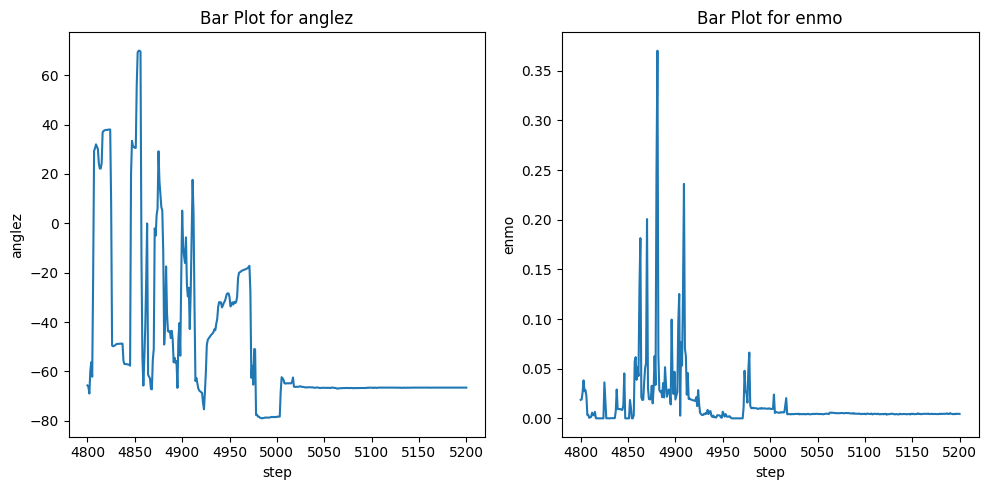

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
for i, col in enumerate(['anglez', 'enmo']):
    sns.lineplot(data=sample, x='step', y=col, ax=axes[i])
    axes[i].set_title(f"Bar Plot for {col}")
plt.tight_layout()
plt.show()

## Data engineering

### Adjust Date format 

- split the current timestamp into year/month/day/hour/minute/seconds fields

### Data cleaning

We start by removing rows without timestamp, as they leads to error when converting the datetime. We will see later if it's possible 
to infer the timestamp for these values, but as the step is also missing, it might be really difficult.

This concerns 51% of the data which is quite huge, but I will not be able to train a model without the timestamp at the moment so we will need
to deal with it.

In [294]:
print(f"Percentage data without timestamp: {round(df.timestamp.isna().sum() / df.timestamp.count() * 100,0)}%")
print(f"Percentage data without step: {round(df.step.isna().sum() / df.step.count() * 100,0)}%")

Percentage data without timestamp: 51.0%
Percentage data without step: 51.0%


In [295]:
# remove the rows with no timestamp
df_cleaned = df[df.timestamp.notna()].copy()
print(f"Percentage data without timestamp: {round(df_cleaned.timestamp.isna().sum() / df_cleaned.timestamp.count() * 100,0)}%")
print(f"Percentage data without step: {round(df_cleaned.step.isna().sum() / df_cleaned.step.count() * 100,0)}%")

Percentage data without timestamp: 0.0%
Percentage data without step: 0.0%


If we attemp to convert the datetime field using pd.to_datetime, we might have errors due to the following rows for example:

In [296]:
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

In [297]:
problematic_row = df_cleaned.loc[54]
print(problematic_row)
problematic_row['timestamp'] = problematic_row['timestamp'].astimezone(datetime.timezone.utc)
print(problematic_row)


series_id                 03d92c9f6f8a
night                                5
event                            onset
step                           75756.0
timestamp    2018-06-04 21:13:00-04:00
Name: 54, dtype: object
series_id                 03d92c9f6f8a
night                                5
event                            onset
step                           75756.0
timestamp    2018-06-05 01:13:00+00:00
Name: 54, dtype: object


This timestamp is in the format YYYY-MM-DD HH:MM:SS±HH:MM, which includes the time zone offset of "-04:00" (meaning it's 4 hours behind UTC).

The issue arises because pandas is trying to convert this timestamp to a datetime64 object. However, datetime64 objects in pandas are not designed to handle time zone offsets. To convert a timezone-aware datetime to datetime64, we will convert it to UTC first:

In [298]:
def convert_df_timestamp_to_utc(to_convert_df):
    to_convert_df['timestamp'] = to_convert_df['timestamp'].apply(lambda x: x.astimezone(datetime.timezone.utc) if x.tzinfo else x)
    return to_convert_df

df_cleaned = convert_df_timestamp_to_utc(df_cleaned)
df_cleaned.dtypes

series_id                 object
night                      int64
event                     object
step                     float64
timestamp    datetime64[ns, UTC]
dtype: object

In [299]:
def split_timestamp(dataframe):
    dataframe['year'] = dataframe.timestamp.dt.year
    dataframe['month'] = dataframe.timestamp.dt.month
    dataframe['day'] = dataframe.timestamp.dt.day
    dataframe['hour'] = dataframe.timestamp.dt.hour
    dataframe['minute'] = dataframe.timestamp.dt.minute
    dataframe['second'] = dataframe.timestamp.dt.second
    return dataframe

In [300]:
df_cleaned = split_timestamp(df_cleaned)
df_cleaned.drop(columns=['timestamp'], inplace=True)
df_cleaned.head()

,series_id,night,event,step,year,month,day,hour,minute,second
0,038441c925bb,1,onset,4992.0,2018,8,15,2,26,0
1,038441c925bb,1,wakeup,10932.0,2018,8,15,10,41,0
2,038441c925bb,2,onset,20244.0,2018,8,15,23,37,0
3,038441c925bb,2,wakeup,27492.0,2018,8,16,9,41,0
4,038441c925bb,3,onset,39996.0,2018,8,17,3,3,0


In [320]:
# we can combine everything into one function
def rm_timestamp_nan_and_split_date(to_convert):
    n_null = to_convert.timestamp.isna().sum() 
    if n_null > 0:
        # print(f"Percentage data without timestamp before cleaning: {round(to_convert.timestamp.isna().sum() / to_convert.timestamp.count() * 100,0)}%")
        to_convert = to_convert[to_convert.timestamp.notna()]
        # print(f"Percentage data without timestamp after cleaning: {round(to_convert.timestamp.isna().sum() / to_convert.timestamp.count() * 100,0)}%"))
    print("1")
    to_convert['timestamp'] = pd.to_datetime(to_convert['timestamp'])
    print("2")
    to_convert = convert_df_timestamp_to_utc(to_convert)
    print("3")
    to_convert = split_timestamp(to_convert)
    print("4")
    to_convert.drop(columns=['timestamp'], inplace=True)
    print("5")
    return to_convert

In [326]:
# only on a subset of the data atm as takes ~ 700 seconds on full dataset on my machine so should be even slower on Kaggle
df_series_cleaned = rm_timestamp_nan_and_split_date(df_series.head(1_000_000))
#df_series_cleaned = rm_timestamp_nan_and_split_date(df_series.head(127_946_340))
df_series_cleaned.head()

1
2
3
4
5


,series_id,step,anglez,enmo,year,month,day,hour,minute,second
0,038441c925bb,0,2.6367,0.0217,2018,8,14,19,30,0
1,038441c925bb,1,2.6368,0.0215,2018,8,14,19,30,5
2,038441c925bb,2,2.6370,0.0216,2018,8,14,19,30,10
3,038441c925bb,3,2.6368,0.0213,2018,8,14,19,30,15
4,038441c925bb,4,2.6368,0.0215,2018,8,14,19,30,20


# Feature ideas:

- this is time series problem, look at kaggle tutorial
- create some indicator, e.g moving average, or # spike in last hour,...
- other 